# Prerequisites

Load your data into a Cloud Storage as CSV, use gzip to compress when necessary.
Use either the web interface, command line tools or the Google Cloud SDK.

    gsutil mb -l EU gs://meteo_data
    gsutil cp ./observations.csv.gz ./paramlist.csv ./station_metadata_filtered.csv gs://meteo_data/observations/
    gsutil rsync ./data gs://meteo_data/observations/

Create a datasetin BigQuery.

    bq mk --data_location EU observations

Creating tables in optional.

    bq mk observations.raw
    bq mk observations.paramlist
    bq mk observations.stations

Load data from Cloud Storage.

    bq load --skip_leading_rows 1 observations.paramlist gs://meteo_data/observations/paramlist.csv paramid,name,description,weather_element,unit,hlevel_scale,standard_hlevel,standard_physical_height,comment,scalar,edited_by,edited_at
    
    bq load --skip_leading_rows 1 observations.stations gs://meteo_data/observations/station_metadata_filtered.csv stationid:integer,name,lat:float,lon:float,fromtime:timestamp,totime:timestamp

    bq load --skip_leading_rows 1 --replace observations.paramlist gs://meteo_data/observations/paramlist.csv paramid:integer,name,description,weather_element,unit,hlevel_scale,standard_hlevel,standard_physical_height,comment,scalar,edited_by,edited_at:timestamp

The field edited_by looks like an integer, check it with a query from the command line. Hope this returns zero to prove that all of the edited_by values are an integer!

    bq query # This looks for the query from standard input, type the query below and press <Ctrl-D>
 
        SELECT
          COUNT(*) AS C
        FROM
          [observations.paramlist]
        WHERE
          INTEGER(edited_by) IS NULL
        LIMIT
          10

How many editors we have?

    SELECT
      edited_by,
      COUNT(*) AS num_of_edits
    FROM
      [observations.paramlist]
    GROUP BY
      edited_by
    ORDER BY
      num_of_edits DESC
    LIMIT
      1000

Earliest observation stations:

    SELECT * FROM [observations.stations] ORDER BY fromtime LIMIT 10

Waiting for job to complete...


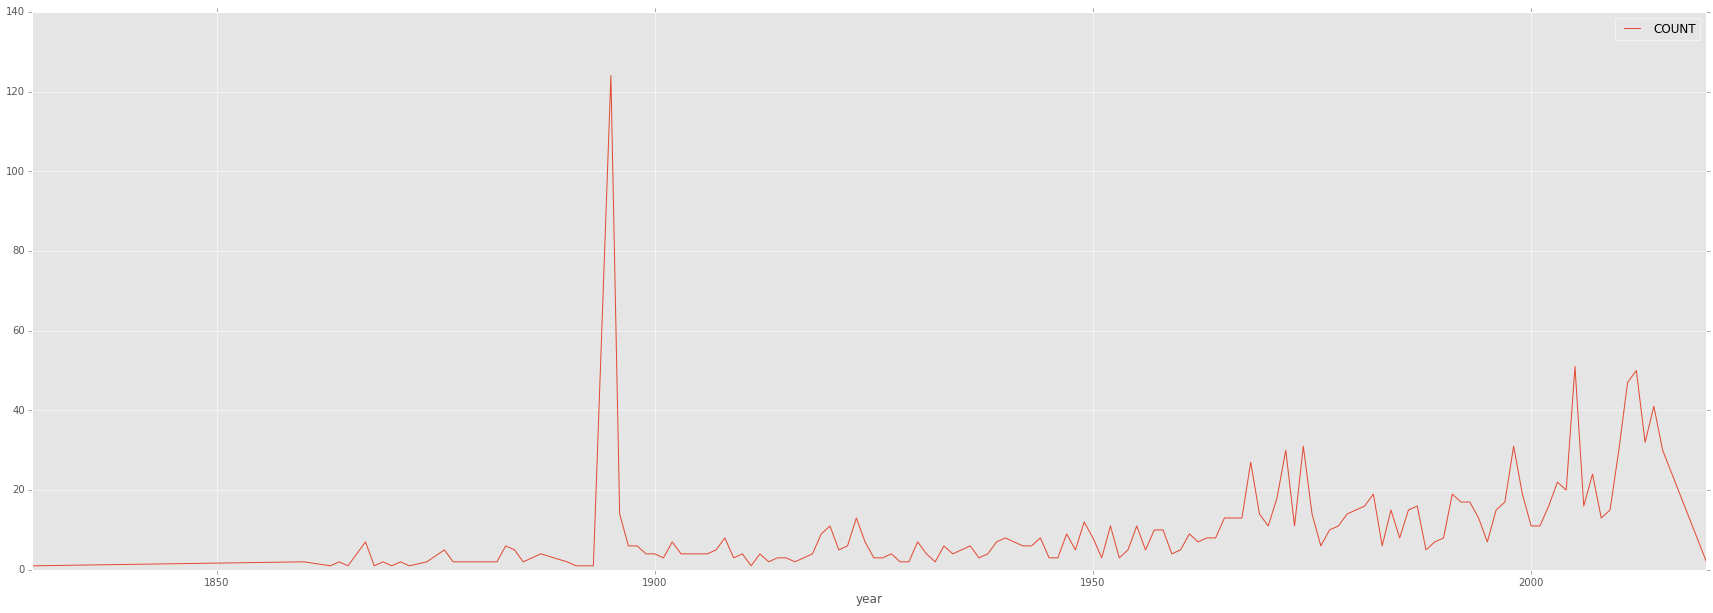

In [1]:
# You can reach BigQuery from programming languages, in this example take Python
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

PROJECT = 'norway-babo-testing'
Q = """
SELECT
  YEAR(fromtime) AS year,
  COUNT(*) AS COUNT
FROM
  [observations.stations]
GROUP BY
  year
ORDER BY
  year ASC
LIMIT
  200
"""
# run a query
df = pd.io.gbq.read_gbq(Q, project_id=PROJECT, index_col='year')

plt.style.use('ggplot')
plt.figure()
df.plot(figsize=(30, 10))

# Loading observation data

Let's try to load observtion data with a simple schema where stationid and typeid are integers, obstime is a timestamp while parameter and rawvalue are strings.

    bq load --skip_leading_rows 1 observations.raw gs://meteo_data/observations/observations.csv.gz stationid:integer,typeid:integer,obstime:timestamp,parameter,rawvalue
    
Well, that returned an error

    BigQuery error in load operation: Error processing job 'norway-babo-testing:bqjob_r10b2098ac6210c0_00000150ad77b9b1_1': Could not parse '2015-06-20 11:00:00+00' as a timestamp.
    Required format is YYYY-MM-DD HH:MM[:SS[.SSSSSS]]
    Failure details:
    - File: 0 / Line:1 / Field:3: Could not parse '2015-06-20
    11:00:00+00' as a timestamp. Required format is YYYY-MM-DD
    HH:MM[:SS[.SSSSSS]]
    - File: 0 / Line:2 / Field:3: Could not parse '2015-06-20
    11:00:00+00' as a timestamp. Required format is YYYY-MM-DD
    HH:MM[:SS[.SSSSSS]]
    - File: 0 / Line:3 / Field:3: Could not parse '2015-06-20
    11:00:00+00' as a timestamp. Required format is YYYY-MM-DD
    HH:MM[:SS[.SSSSSS]]
    - File: 0 / Line:4 / Field:3: Could not parse '2015-06-20
    11:00:00+00' as a timestamp. Required format is YYYY-MM-DD
    HH:MM[:SS[.SSSSSS]]
    
As BigQuery doesn't like our timestamp format, load it as a string.

    bq load --replace --skip_leading_rows 1 observations.raw gs://meteo_data/observations/observations.csv.gz stationid:integer,typeid:integer,obstime,parameter,rawvalue

Use BigQuery as a lighweight ETL tool. Goal is to trasnform data into a new table with corrected types and more. Documentation at https://cloud.google.com/bigquery/query-reference

    bq query --allow_large_results --destination_table observations.observations
        SELECT
          stationid,
          typeid,
          TIMESTAMP(REGEXP_EXTRACT(obstime, r'(.+)\+00$')) as obstime,
          parameter,
          rawvalue,
          float(rawvalue) as floatvalue
        FROM
          [observations.raw]

# Analyze data

The original description says that floatvalue is mostly numerical. How about the none numerical data?

    SELECT
      typeid, parameter, rawvalue
    FROM
      [observations.observations]
    WHERE
      floatvalue IS NULL
    LIMIT
      100;
      
    SELECT
      typeid,
      parameter,
      rawvalue
    FROM
      [observations.observations]
    WHERE
      floatvalue IS NULL
      AND typeid != 330
    LIMIT
      100;
      
    SELECT
      typeid,
      parameter,
      rawvalue
    FROM
      [observations.observations]
    WHERE
      floatvalue IS NULL
      AND typeid == 330
      AND REGEXP_MATCH(rawvalue, r'^N\d+\.\d+[WE]\d+\.\d+$') IS NULL
    LIMIT
      100;
      
    SELECT
      typeid,
      parameter,
      rawvalue,
      FLOAT(REGEXP_EXTRACT(rawvalue, r'^N(.+)[WE].+$')) AS lat,
      FLOAT(REGEXP_EXTRACT(rawvalue, r'^N.+[WE](.+)$')) AS long
    FROM
      [observations.observations]
    WHERE
      floatvalue IS NULL
      AND typeid == 330
    LIMIT
      100;
      
Find temperature like data.

    SELECT
      *
    FROM
      [observations.paramlist]
    WHERE
      unit = "grad C"
    LIMIT
      1000;

Find minimum and maximum temperatures.

    SELECT
      MIN(floatvalue) AS minimum,
      MAX(floatvalue) AS maximum
    FROM
      [observations.observations]
    WHERE
      parameter = 'TA(0,0)';

That returned some strange values, we should just filter them out.

    SELECT
      MIN(floatvalue) AS minimum,
      MAX(floatvalue) AS maximum,
      MONTH(obstime) AS month
    FROM
      [observations.observations]
    WHERE
      parameter = 'TA(0,0)'
      AND floatvalue > -99
      AND floatvalue < 35
    GROUP BY
      month
    ORDER BY
      month
    LIMIT
      12;

Top five stations reporting temperatures below zero.

    SELECT
      t.stationid AS stationid,
      name,
      lat,
      lon,
      t.cnt AS cnt
    FROM
      [observations.stations] AS station
    JOIN (
      SELECT
        TOP (stationid, 5) AS stationid,
        COUNT(*) AS cnt,
      FROM
        [observations.observations]
      WHERE
        parameter = 'TA(0,0)'
        AND floatvalue < 0
        AND floatvalue > -98
        AND YEAR(obstime) = 2015) AS t
    ON
      t.stationid = station.stationid
    WHERE
      totime IS NULL
      OR YEAR(totime) = 2015
    ORDER BY
      cnt DESC
    LIMIT
      10;